# Best Model From Cross Validation and Final Model Training 
Here the `Best Performing Models` from previously trained models using `MobileNetV2` with CV = 5, will be used to train the `Final Models` for both Banana & Maize and their performance evaluated.  5 Fold Cross Validated models for both Banana and Maize performed rather well.  Here are their performance curves.

1. Banana:
   
    ![Banana](images/kfold_best_model_ban.png)

2. Maize:

   ![Maize](images/kfold_best_model_mz.png)

With `Accuracy` and `Loss` Curves showing good metrics, the `Final Model` should give similar or better results.

## Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model, load_model
from keras.callbacks import History

import pandas as pd
import numpy as np
import os
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns


### Configure Model Parameters for Training

In [2]:
# -----------------------------
# Configuration - Banana and Maize for final model building
# -----------------------------
epochs = 50
configs = [
    {
        'name': 'MobileNetV2-Maize',
        'model': MobileNetV2,
        'base_dir': 'data_maize\\data_kfold\\maize',       # Folder containing 5 subfolders (one per class)
        'input_shape': (224, 224, 3),          # Target input shape for MobileNetV2
        'n_classes': 5,
        'batch_size': 32,
        'epochs': epochs,
        'vis_layer': 'conv2d_2'
    },
    {
        'name': 'MobileNetV2-Banana',
        'model': MobileNetV2,
        'base_dir': 'data_banana\\data_kfold\\banana',       # Folder containing 5 subfolders (one per class)
        'input_shape': (224, 224, 3),          # Target input shape for MobileNetV2
        'n_classes': 5,
        'batch_size': 32,
        'epochs': epochs,
        'vis_layer': 'conv2d_2'
    }
]


### Utility Function to Plot Performance of Final Model

In [3]:
## Plot Accuracy, Loss, Precision, Recall curves for the trained model
def plot_final_model_performance_curve(modelname, model_hist, foldername):  
    accuracy = model_hist.history['accuracy']
    loss = model_hist.history['loss']
    precision = model_hist.history['precision']
    recall = model_hist.history['recall']

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(10, 6))  

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, accuracy, 'go-', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precision, 'ro-', label='Training Precision')
    plt.title('Training Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plot Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, recall, 'mo-', label='Training Recall')
    plt.title('Training Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.suptitle(modelname, fontsize=18)
    plt.tight_layout()
    
    t = datetime.now()
    # filename = t.strftime(f"{foldername}\\{modelname}_perf_plot_%y_%m_%d_%H_%M_%S.png")
    filename = t.strftime(f"{foldername}\\{modelname}_perf_plot_%H%M%S.png")
    print(filename)
    plt.savefig(filename, bbox_inches='tight', dpi=125)    
    plt.show()
    

In [4]:
#Plot the confusion Matrix in a heatmap with values of predictions
def plot_confusion_matrix(cm, class_names, title='Confusion matrix'):
    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt="g",cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted Label', fontsize=15)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=45)
    ax.xaxis.set_ticklabels(class_names, fontsize = 12)
    ax.xaxis.tick_bottom()
    
    ax.set_ylabel('True Label', fontsize=15)
    ax.yaxis.set_ticklabels(class_names, fontsize = 12)
    plt.yticks(rotation=0)
    
    plt.title('Confusion Matrix', fontsize=20)

In [5]:
# Visualize feature maps
def visualize_feature_maps(model, modelname, layer_name, img_path, foldername):
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    img = image.load_img(img_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  
    
    feature_maps = intermediate_model.predict(x)
    
    fig = plt.figure(figsize=(15, 15))
    for i in range(min(64, feature_maps.shape[-1])):
        ax = fig.add_subplot(8, 8, i + 1)
        feature_map = feature_maps[0, :, :, i]
        # Handle division by zero
        if feature_map.std() == 0:
            feature_map = feature_map - feature_map.mean()
        else:
            feature_map = (feature_map - feature_map.mean()) / feature_map.std()        
        feature_map *= 64
        feature_map += 128
        feature_map = np.clip(feature_map, 0, 255).astype('uint8')
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
    
    plt.suptitle(f'Feature Map Visualization-{modelname}', fontsize=20)        
    plt.tight_layout()
    t = datetime.now()
    filename = t.strftime(f"{foldername}/{modelname}_%Y_%m_%d_%H_%M_%S_fmap.png")    
    plt.savefig(filename, bbox_inches='tight', dpi=92)
    plt.show()


### Build Dataframe of Training Images
Here there is no need to split the images into Train and Validation sets.  All images will be used for training.  The images need to split only into the number of classes.  Here the images are split into 5 folders
1. **Banana**: `bs_high`, `bs_low`, `fw_high`, `fw_low` and `healthy` comprising both `Black Sigatoka` and `Fusarium Wilt` diseases
2. **Maize**: `mln_high`, `mln_low`, `msv_high`, `msv_low` and `healthy` comprising both `Maize Lethal Necrosis` and `Maize Streak Virus` diseases

In [6]:
# -----------------------------
# Build a DataFrame of all images.  This will create a dataframe containing paths to the image files
# which will be used during the training.
# -----------------------------
def build_dataframe(directory):
    data_list = []
    # Each subfolder in "directory" is a separate class
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(class_path, file)
                    data_list.append({'filename': file_path, 'class': class_name})
    return pd.DataFrame(data_list)


### Train the Model on FULL Dataset - Banana
After 5 Fold cross validations using MobileNetV2, in the final training exercise, **ALL** images will be used ***without*** splitting in to `Training` and `Validation` sets.  This is the recommended for improving the learning performances

Found 8058 validated image filenames belonging to 5 classes.
data_banana\data_kfold\selectedmodels\Final_Model_Banana_perf_plot_031758.png


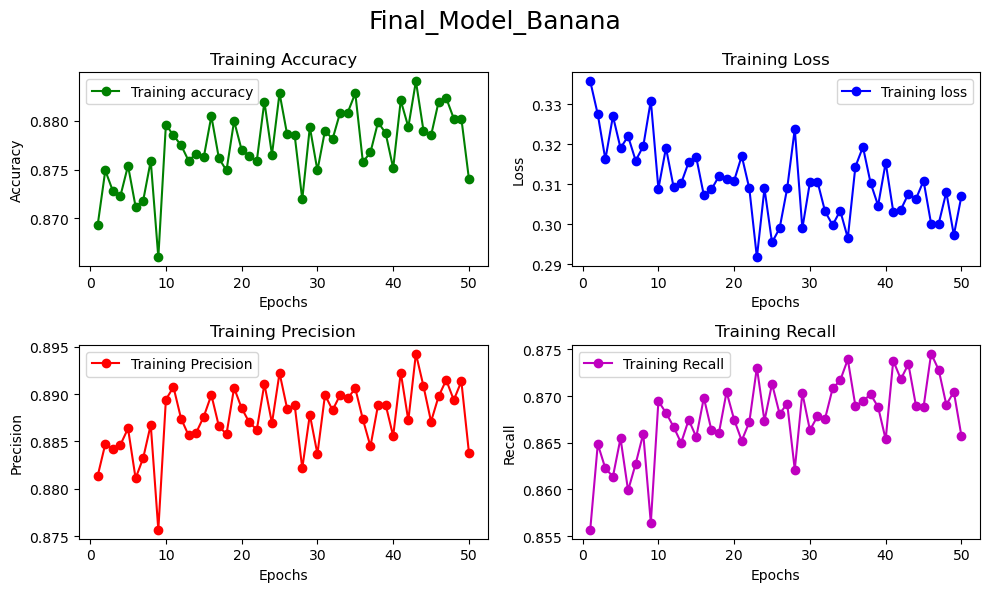

In [13]:

# Maize config from configs
config = configs[1]
# 1. Load the Best Model (from the previous MobileNetV2 trained model)
best_model_path = 'data_banana\\data_kfold\\selectedmodels\\best_model_ban.h5'
final_model = tf.keras.models.load_model(best_model_path)

# 2. Prepare full image dataset
full_df = build_dataframe(config['base_dir'])

# 3. Data Augmentation for Full Dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=full_df,
    x_col="filename",
    y_col="class",
    target_size=config['input_shape'][:2],
    batch_size=32,
    class_mode='categorical'
)

#Rebuild the MobileNetV2 base and Top layers, then load weights.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=config['input_shape'],
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

#set learning rate.
learning_rate = 0.001 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


new_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(config['n_classes'], activation='softmax')
])

#Load the weights from the previously trained model.
new_model.set_weights(final_model.get_weights())

#Replace final_model with new_model
final_model = new_model

# 5. Train the Final Model
final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')]
)

history = final_model.fit(
    train_generator,
    epochs=config['epochs'],
    steps_per_epoch=len(train_generator),verbose=0
)

foldername = 'data_banana\\data_kfold\\selectedmodels'

# Save the final model
final_model.save(f'{foldername}\\final_model.h5')

# Optional, save training history.
save_dict = {
        "history": history.history,
        "params": history.params
    }
filename = f"{foldername}\\final_model_hist_and_params.json"
with open(filename, 'w') as f:
    json.dump(save_dict, f)

# plot the metrics
plot_final_model_performance_curve('Final_Model_Banana', history, foldername)

### Train the Model on FULL Dataset - Maize
After 5 Fold cross validations using MobileNetV2, in the final training exercise, **ALL** images will be used ***without*** splitting in to `Training` and `Validation` sets.  This is the recommended for improving the learning performances

Found 6067 validated image filenames belonging to 5 classes.
data_maize\data_kfold\selectedmodels\maize\Final_Model_Maize_perf_plot_034033.png


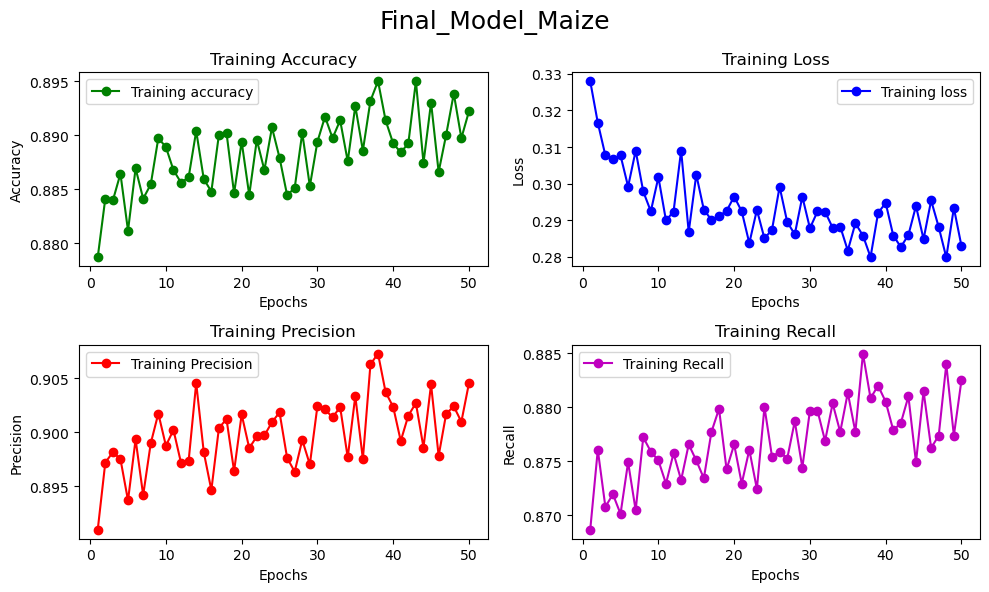

In [14]:

# Maize config from configs
config = configs[0]
# 1. Load the Best Model (Replace with your actual path)
best_model_path = 'data_maize\\data_kfold\\selectedmodels\\best_model_mz.h5'
final_model = tf.keras.models.load_model(best_model_path)

# 2. Prepare full image dataset
full_df = build_dataframe(config['base_dir'])

# 3. Data Augmentation for Full Dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=full_df,
    x_col="filename",
    y_col="class",
    target_size=config['input_shape'][:2],
    batch_size=32,
    class_mode='categorical'
)

#Rebuild the MobileNetV2 base and Top layers, then load weights.
base_model = tf.keras.applications.MobileNetV2(
    input_shape=config['input_shape'],
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

#set learning rate.
learning_rate = 0.001 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


new_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(config['n_classes'], activation='softmax')
])

#Load the weights from the previously trained model.
new_model.set_weights(final_model.get_weights())

#Replace final_model with new_model
final_model = new_model

# 5. Train the Final Model
final_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall')]
)

history = final_model.fit(
    train_generator,
    epochs=config['epochs'],
    steps_per_epoch=len(train_generator),verbose=0
)

foldername = 'data_maize\\data_kfold\\selectedmodels\\maize'

# Save the final model
final_model.save(f'{foldername}\\final_model.h5')

# Optional, save training history.
save_dict = {
        "history": history.history,
        "params": history.params
    }
filename = f"{foldername}\\final_model_hist_and_params.json"
with open(filename, 'w') as f:
    json.dump(save_dict, f)

# plot the metrics
plot_final_model_performance_curve('Final_Model_Maize', history, foldername)

# Test Trained Models

### Load Saved Banana model for testing and Performance Evaluation


In [5]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix 

In [6]:
# Load from the 'banana_final_model.h5' file
path_to_model = os.path.normpath('data_banana\\test_banana\\banana_final_model.h5')
banana_model = tf.keras.models.load_model(path_to_model) 

In [7]:
#path to test images
test_img_path = os.path.normpath('data_banana\\test_banana\\images')
# Generator for our testing data, batch = 1 so one image at a time can be tested.
test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
                                              test_img_path,
                                              batch_size=1,
                                              shuffle=False,
                                              target_size=(224,224), 
                                              class_mode='categorical')


Found 103 images belonging to 5 classes.


### Evaluate the Final Model - Banana

In [9]:
# Check if the model loaded without any errors
loss, acc, precision, recall = banana_model.evaluate(test_generator)

103/103 [==============================] - 1s 9ms/step - loss: 0.6287 - accuracy: 0.8350 - precision: 0.8600 - recall: 0.8350


In [8]:
final_model_preds = banana_model.predict(test_generator)
final_model_preds_class_indices = np.argmax(final_model_preds, axis=1)
# Map indices back to string labels
# {0: 'bs_high', 1: 'bs_low', 2: 'fw_high', 3: 'fw_low', 4: 'healthy'}
# bs = Black Sigaitoka, fw = Fusarium Wilt.

class_mapping = {v: k for k, v in test_generator.class_indices.items()}  

# get the predicted results from the model
final_model_preds_labels = [class_mapping[idx] for idx in final_model_preds_class_indices]

#the actual classes 
true_class_indices = test_generator.classes
true_class_labels = [class_mapping[i] for i in true_class_indices]
# correct predictions 
correct_indices = np.where(final_model_preds_class_indices == true_class_indices)[0]
correct_labels = [class_mapping[final_model_preds_class_indices[i]] for i in correct_indices]
# incorrect classification
incorrect_indices = np.where(final_model_preds_class_indices != true_class_indices)[0]
incorrect_labels = [class_mapping[true_class_indices[i]] for i in incorrect_indices]

# Save results to CSV
results = pd.DataFrame({
    'Image Path': test_generator.filepaths,
    'Predicted Label': final_model_preds_labels,
    'Actual Label' : true_class_labels
})
# results.head(50)
results.to_excel(f'{os.path.dirname(test_img_path)}\\predictions_banana.xlsx', index=False)

103/103 [==============================] - 5s 10ms/step


### Plot the confusion Matrix in a heatmap with values of predictions

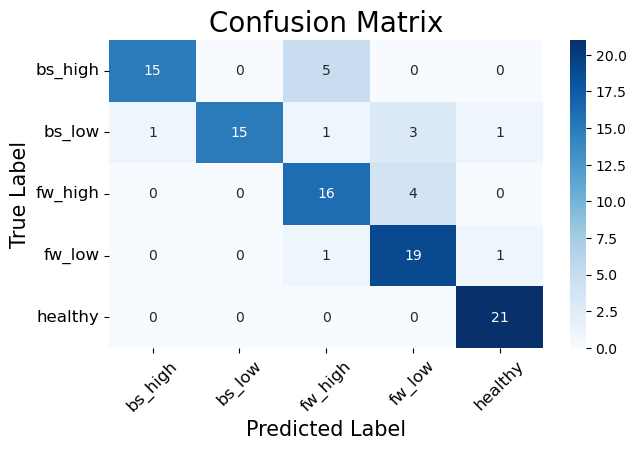

In [29]:
cm = confusion_matrix(true_class_indices, final_model_preds_class_indices)
# [*class_mapping.values()]
plot_confusion_matrix(cm,list(class_mapping.values()))

### Evaluation Metrics of Final Fully Trained Model - Banana
<table>
<tr><td>Metrics</td><td>Training Average</td></tr>   
<tr><td>Loss</td><td>29.1%</td></tr>
<tr><td>Accuracy</td><td>88.2%</td></tr>
<tr><td>Precision</td><td>89.2%</td></tr>
<tr><td>Recall</td><td>86.9%</td></tr>
<tr><td>F1 Score</td><td>88.0%</td></tr> 
</table>


In [47]:
with open('data_banana\\test_banana\\banana_final_model_hist_and_params.json', 'r') as f:
    loaded_history_dict = json.load(f)

test_banana\Final Model Banana_perf_plot_152622.png


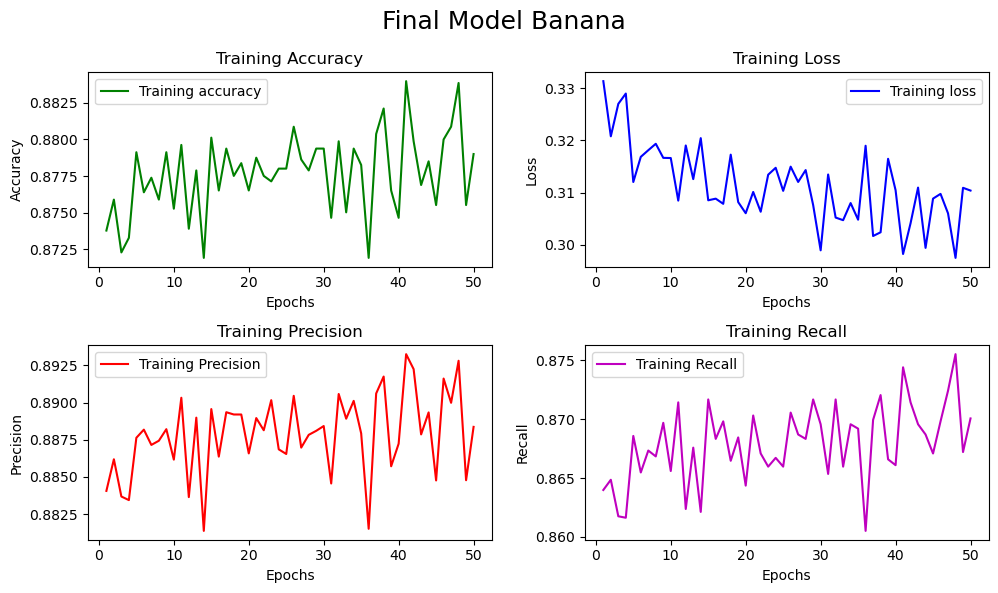

In [48]:
finalmodel_history = History()
finalmodel_history.history = loaded_history_dict['history']
plot_final_model_performance_curve('Final Model Banana', finalmodel_history , "test_banana")

### Evaluation Metrics of Final Fully Trained Model - Maize
<table>
<tr><td>Metrics</td><td>Training Average</td></tr>   
<tr><td>Loss</td><td>28%</td></tr>
<tr><td>Accuracy</td><td>89.3%</td></tr>
<tr><td>Precision</td><td>90.3%</td></tr>
<tr><td>Recall</td><td>87.6.5%</td></tr>
<tr><td>F1 Score</td><td>88.9%</td></tr> 
</table>


In [40]:
with open('data_maize\\test_maize\\maize_final_model_hist_and_params.json', 'r') as f:
    loaded_history_dict = json.load(f)

test_maize\Final Model Maize_perf_plot_152606.png


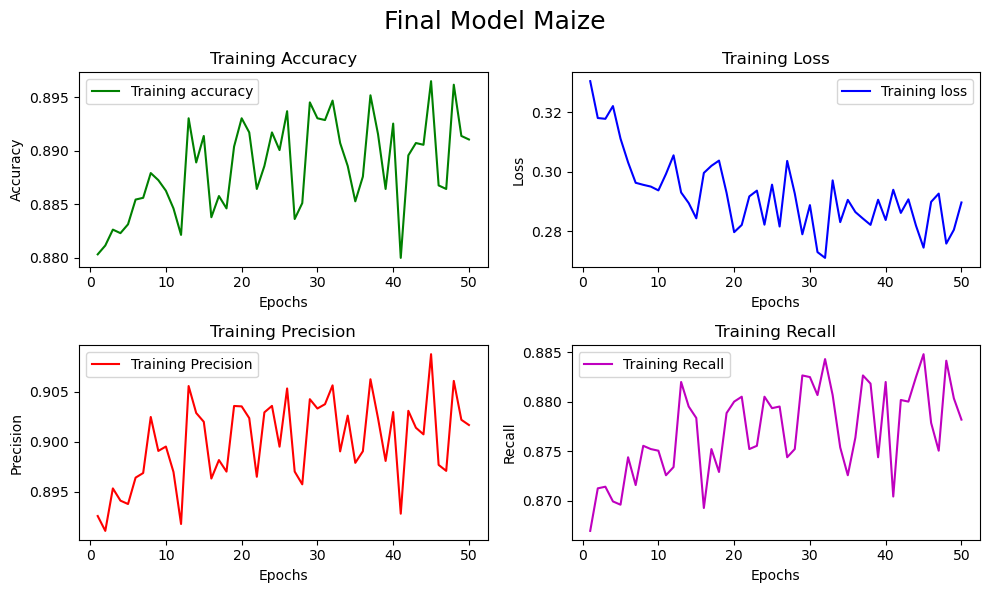

In [46]:
finalmodel_history = History()
finalmodel_history.history = loaded_history_dict['history']
plot_final_model_performance_curve('Final Model Maize', finalmodel_history , "test_maize")

# Conclusion
In conclusion it is fair to say that these image classifier models can be used to detect the diseases in Banana and Maize crops. The models have been trained on a limited dataset and have shown good performance. The models can be further improved by adding more data, more training and fine tuning the hyperparameters. The models can be used to detect the diseases in the early stages and provide recommendations to respective stakeholders in crop manangement. This can help in reducing the impact of the diseases and improve the yield and quality of the crops.


## Positive Effect of Fighting Crop Loss
Currently world over, the crop loss is estimated to be `25%-30 annually`. If effective steps are taken to combat this crop loss, we can address many of the societal problems like:
1. Food security
2. Infant and adult malnutrition
3. Skyrocketing inflation
4. Large-scale social disturbances
and more...

#### Banana:
Major diseases affecting the wonderful fruit of Banana (other than the two considered in the project) globally are:
1. **Banana Bunchy Top Virus**: This is serious virus that is major threat to Banana Plantations worldwide. If left unattended to, with in few seasons (starting with 70%-90% in first season), it results in nearly `100%` crop loss.
2. **Yellow Sigatoka**: This fungal disease causes the younger leaves to prematurely die, smaller bananas, yield losses (about`50%`) and eventual death of the plant.
3. **Moko Disease**: This bacterial wilt disease, usually transmitted by insects, rain and irrigation, causes the leaf blades to turn yellow, premature fruit ripening, fruit discoloration and eventually turning black.

#### Maize
Major Crop Diseases affecting Maize Crop (other than 2 considered for the project) are:
1. Gray Leaf Spot: This is number 1 disease in all corn production. It manifests as gray to tan, rectangular lesions on leaves, sheaths, and husks, and can lead to significant yield reduction. 
2. Fusarium Ear Rot : This cause major problems worldwide with reducing yield, grain quality and causes health issues in humans and livestock with `Mycotoxin Production`
3. Charcoal Rot : This fungal disease thrives in hot and humid conditions (South Asia, Africa and South America) causes premature-maturity, reduced root strength and plant death affecting overall crop yield
4. Tar Rust: A relatively new and emerging disease in the United States, tar spot is caused by the fungus Phyllachora maydis and is characterized by small, raised black spots that resemble fisheyes on both sides of leaves. It can lead to leaf deterioration, poor grain fill, and yield losses

Even, if the crop losses are reduced by `10%` or `20%` globally, the Gross Production Value generated by the crop producing countries will save substantial amounts of money. We are talking about `**Billions of US$**` that can be put to better use.



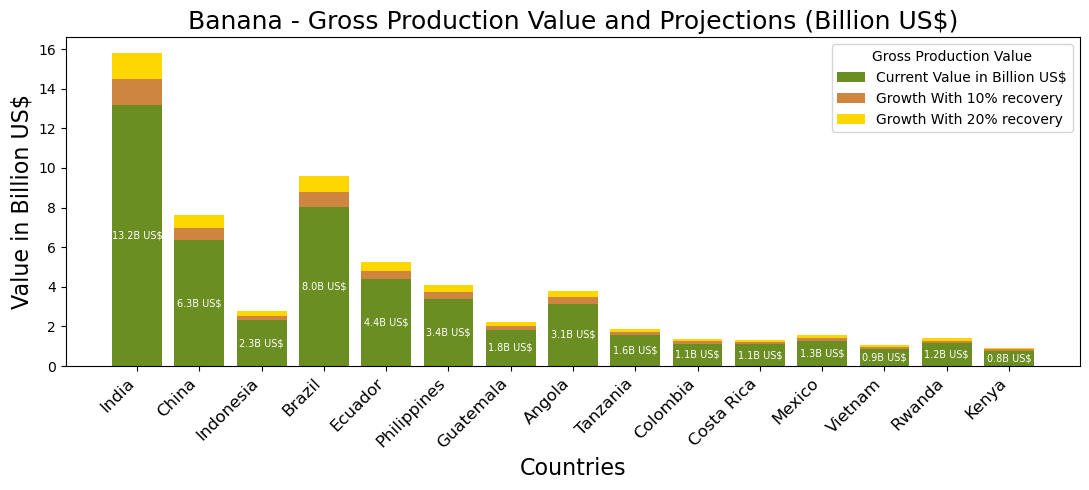

In [54]:
# Bar chart showing projections of  Gross Production Value growth when
# 1. 10% control on disease is achieved
# 2. 20% control on disease is achieved

# read the csv file containing banana data
filename = 'data_banana\\top_15_banana_data.csv'
banana = pd.read_csv(filename)
value_usd = banana['value_usd']/1000000000
projection_10 = banana['projection_10']/1000000000
projection_20 = banana['projection_20']/1000000000
country_names = banana['country']
# Create a stacked bar chart
plt.figure(figsize=(11, 5))
bars1 = plt.bar(range(len(value_usd)), value_usd, 
                label='Current Value in Billion US$', color='olivedrab' )
bars2 = plt.bar(range(len(value_usd)), projection_10, bottom=value_usd, 
        label='Growth With 10% recovery ', color='peru')
bars3 = plt.bar(range(len(value_usd)), 
        projection_20 - projection_10, 
        bottom=value_usd + projection_10, 
        label='Growth With 20% recovery',color='gold')

# Display values in the middle of the bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height/2, 
             f'{height:.1f}B US$', ha='center', color='w', va='center', size=7)

plt.xticks(range(len(country_names)), country_names, rotation=45, fontsize=12, ha='right')
plt.xlabel('Countries',fontsize=16)
plt.ylabel('Value in Billion US$',fontsize=16)
plt.title('Banana - Gross Production Value and Projections (Billion US$)',fontsize=18)
plt.legend(title="Gross Production Value",fontsize=10)
plt.tight_layout()
file = '04_banana_prev_potential.png'
plt.savefig(f'images/{file}', bbox_inches='tight', dpi=175)
plt.show()

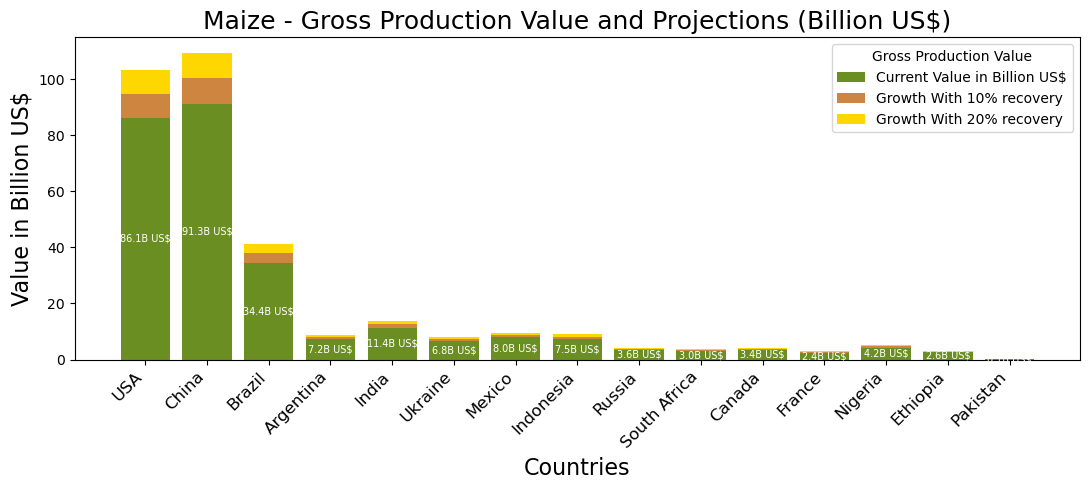

In [55]:
# Bar chart showing projections of  Gross Production Value growth when
# 1. 10% control on disease is achieved
# 2. 20% control on disease is achieved
# read the csv file containing banana data

filename = 'data_maize\\top_15_maize_data.csv'
maize = pd.read_csv(filename)

value_usd = maize['value_usd']/1000000000
projection_10 = maize['projection_10']/1000000000
projection_20 = maize['projection_20']/1000000000
country_names = maize['country']
# Create a stacked bar chart
plt.figure(figsize=(11, 5))
bars1 = plt.bar(range(len(value_usd)), value_usd, 
                label='Current Value in Billion US$', color='olivedrab' )
bars2 = plt.bar(range(len(value_usd)), projection_10, bottom=value_usd, 
        label='Growth With 10% recovery ', color='peru')
bars3 = plt.bar(range(len(value_usd)), 
        projection_20 - projection_10, 
        bottom=value_usd + projection_10, 
        label='Growth With 20% recovery',color='gold')

# Display values in the middle of the bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height/2, 
             f'{height:.1f}B US$', ha='center', color='w', va='center', size=7)

plt.xticks(range(len(country_names)), country_names, rotation=45, fontsize=12, ha='right')
plt.xlabel('Countries',fontsize=16)
plt.ylabel('Value in Billion US$',fontsize=16)
plt.title('Maize - Gross Production Value and Projections (Billion US$)',fontsize=18)
plt.legend(title="Gross Production Value",fontsize=10)
plt.tight_layout()
file = '04_maize_prev_potential.png'
plt.savefig(f'images/{file}', bbox_inches='tight', dpi=200)
plt.show()

# Recommendations, Next Steps and Future Work
1. Train the models on a larger dataset especially for the diseases with low severity infection levels in both Banana and Maize crops
2. Fine tune the hyperparameters of the models to improve the performance
3. Train the models on other crops like Tomato, Potato, Cucumbers, Melons, etc. to build a multi-crop disease detection Model
4. Build a Test application for testing the models
5. Deploy the models on the cloud for real-time disease detection
6. Integrate the models with other tools like drones, IoT devices, etc. for better disease detection and management in the fields


#### References

- *USDA NIFA https://www.nifa.usda.gov/about-nifa/blogs/researchers-helping-protect-crops-pests*
- *World Food Programme : https://www.wfp.org/global-hunger-crisis*
- *Center for Strategic & International Studies: https://www.csis.org/analysis/dangerously-hungry-link-between-food-insecurity-and-conflict*
- *Uncontained spread of Fusarium wilt of banana threatens African food security
https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1010769*
- *Maize Streak Virus
https://www.sciencedirect.com/science/article/abs/pii/B978012374410400707X*
- *https://www.sciencedirect.com*
- *https://www.faostat.com*
- *https://cahfsa.org/*
- *https://iimr.icar.gov.in/?page_id=2134 Indian Council for Agricultural Research*
- *https://apsjournals.apsnet.org/doi/10.1094/PHP-05-20-0038-RS*
- *https://www.cropscience.bayer.us/articles/bayer/general-leaf-diseases-of-corn*

## THE END